In [1]:
import os
import math
import numpy as np
import h5py
import glob
from tqdm import tqdm
import scipy

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.ion()

# Read in deep drive data
dfiles = glob.glob('data/*.h5')
dfiles = glob.glob('/Users/davidleifer/Desktop/DanDoesData/self-driving/train_0000.h5')


Using Theano backend.


In [2]:
model.fit?

Object `model.fit` not found.


Epoch 1/10
999/999 [==============================] - 3s - loss: 0.1028 - dense_6_loss: 0.0773 - dense_7_loss: 0.0256 - dense_6_acc: 0.1702 - dense_7_acc: 0.1932     
Epoch 2/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 3/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 4/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 5/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 6/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932    

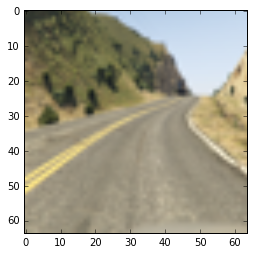

In [3]:
plt.ion()
%matplotlib inline

# Read in deep drive data
#dfiles = glob.glob('data/*.h5')
dfiles = glob.glob('/Users/davidleifer/Desktop/DanDoesData/self-driving/train_0000.h5')

dfile = dfiles[0]

h5f = h5py.File(dfile,'r')
A = dict(h5f.items())

plt.imshow(A['images'].value[0].swapaxes(0,2).swapaxes(0,1))
AA = A['images'].value

# look at targets
A['targets'].value[:2]
A['vehicle_states'].value[:2]

at = A['targets'].value[:-1]
av = A['vehicle_states'].value[1:]

# slim inputs
B = np.array(A['images'].value,dtype=np.uint8)
plt.imshow(B[0][::-1,:,:].transpose((1,2,0)))

B = B[:,::-1,:,:]

bb = scipy.misc.imresize(B[0],(128,128),'cubic','RGB')
plt.imshow(bb)

bb = scipy.misc.imresize(B[0],(64,64),'cubic','RGB')
plt.imshow(bb)

speedmax = None
speedmin = None
accelmax = None
accelmin = None

ndata = 0
imgsize = 64
# frame size
nrows = 64
ncols = 64

# speed, accel, distance, angle
real_in = Input(shape=(2,), name='real_input')

# video frame in, grayscale
frame_in = Input(shape=(3,nrows,ncols))

# convolution for image input
conv1 = Convolution2D(8,5,5,border_mode='same')
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D(pool_size=(2,2))(Econv_l1)

conv2 = Convolution2D(8,5,5,border_mode='same')
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D(pool_size=(2,2))(Econv_l2)

flat = Flatten()(pool_l2)

M = merge([flat,real_in], mode='concat', concat_axis=1)

D1 = Dense(64)(M)
ED1 = ELU()(D1)
D2 = Dense(32)(ED1)
ED2 = ELU()(D2)
D3 = Dense(32)(ED2)
ED3 = ELU()(D3)

A1 = Dense(32)(ED3)
EA1 = ELU()(A1)
S1 = Dense(32)(ED3)
ES1 = ELU()(S1)

Accel = Dense(1, activation='sigmoid')(EA1)
Steer = Dense(1, activation='sigmoid')(ES1)

model = Model(input=[real_in, frame_in], output=[Accel,Steer])

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        #speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        #speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = A['targets'].value[:,4:]

h = model.fit([speedx, imgs], [targets[:,1], targets[:,0]],
                batch_size = 32, nb_epoch=10, verbose=1)

In [7]:
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        #speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        #speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = A['targets'].value[:,4:]

        h = model.fit([speedx, imgs], [targets[:,1], targets[:,0]],
                        batch_size = 32, nb_epoch=10, verbose=1)
        all_pred.append(h)

Epoch 1/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 2/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 3/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 4/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 5/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 6/10
999/999 [==============================] - 5s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932    

NameError: name 'all_pred' is not defined

In [8]:
all_pred = list()

In [11]:
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        #speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        #speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = A['targets'].value[:,4:]

        h = model.fit([speedx, imgs], [targets[:,1], targets[:,0]],
                        batch_size = 32, nb_epoch=10, verbose=1)
        all_pred.append(h)

Epoch 1/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 2/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 3/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 4/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 5/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 6/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932    

In [12]:
all_pred

In [18]:
speedmax = None
speedmin = None
accelmax = None
accelmin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        #rawr data
        A = dict(h5f.items())
        smx = np.max(A['vehicle_states'].value[:,2])
        smn = np.min(A['vehicle_states'].value[:,2])
        amx = np.max(A['vehicle_states'].value[:,3])
        amn = np.min(A['vehicle_states'].value[:,3])
        if speedmax is None or smx > speedmax:
            speedmax = smx
        if speedmin is None or smn < speedmin:
            speedmin = smn
        if accelmax is None or amx > accelmax:
            accelmax = amx
        if accelmin is None or amn < accelmin:
            accelmin = amn

In [19]:
speedmax

0.80211598

In [20]:
speedmin

-0.011074

In [21]:
accelmin

-0.184782

In [22]:
accelmax

0.1761

In [23]:
# steering is nominally -1 to 1, but doesn't go below zero?
throttlemax = None
throttlemin = None
steermax = None
steermin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        smx = np.max(A['targets'].value[:,4])
        smn = np.min(A['targets'].value[:,4])
        tmx = np.max(A['targets'].value[:,5])
        tmn = np.min(A['targets'].value[:,5])
        if steermax is None or smx > steermax:
            steermax = smx
        if steermin is None or smn < steermin:
            steermin = smn
        if throttlemax is None or tmx > throttlemax:
            throttlemax = tmx
        if throttlemin is None or tmn < throttlemin:
            throttlemin = tmn

In [24]:
throttlemax

0.964239

In [25]:
throttlemin

0.0

In [26]:
steermax

0.52631599

In [27]:
steermin

-1.0

In [37]:
dfile = dfiles[0]

h5f = h5py.File(dfile,'r')
A = dict(h5f.items())


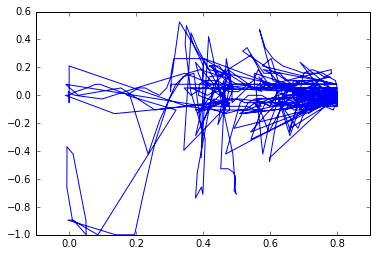

In [33]:
plt.plot(A['targets'].value[:,2],A['targets'].value[:,4])

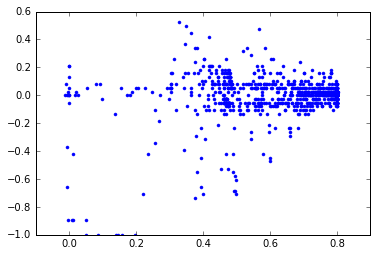

In [34]:
plt.plot(A['targets'].value[:,2],A['targets'].value[:,4],'.')

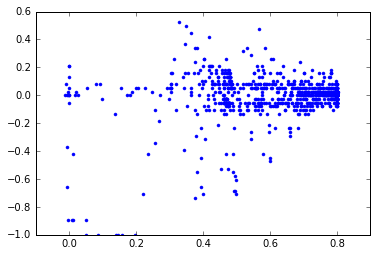

In [38]:
speedmax = None
speedmin = None
accelmax = None
accelmin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        #rawr data
        A = dict(h5f.items())
        smx = np.max(A['vehicle_states'].value[:,2])
        smn = np.min(A['vehicle_states'].value[:,2])
        amx = np.max(A['vehicle_states'].value[:,3])
        amn = np.min(A['vehicle_states'].value[:,3])
        if speedmax is None or smx > speedmax:
            speedmax = smx
        if speedmin is None or smn < speedmin:
            speedmin = smn
        if accelmax is None or amx > accelmax:
            accelmax = amx
        if accelmin is None or amn < accelmin:
            accelmin = amn
        plt.plot(A['targets'].value[:,2],A['targets'].value[:,4],'.')

In [39]:
all_pred = list()
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = A['targets'].value[:,4:]

        h = model.fit([speedx, imgs], [targets[:,1], targets[:,0]],
                        batch_size = 32, nb_epoch=10, verbose=1)
        all_pred.append(h)

Epoch 1/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 2/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 3/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 4/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 5/10
999/999 [==============================] - 3s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932     
Epoch 6/10
999/999 [==============================] - 4s - loss: 0.0839 - dense_6_loss: 0.0593 - dense_7_loss: 0.0246 - dense_6_acc: 0.1752 - dense_7_acc: 0.1932    